# Risk parity on two assets, 南华商品，中债净价(3-5年)

### 1. import modules

In [2]:
import pandas as pd
import numpy as np
import os
np.random.seed(1000)
import scipy.stats as scs
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image, display
from scipy.optimize import minimize
import time

### 2. get data

In [3]:
data = pd.read_csv('./assets.csv', index_col='Date', parse_dates=True).rename(columns={"CBA00332.CS":"Bond","NH0100.NHF":"Commodity","000300.SH":"Equity"})
data.head()

,Bond,Commodity,Equity
Date,,,
2008-08-21,112.6504,1329.2136,2443.979
2008-08-22,112.6684,1339.8214,2404.928
2008-08-25,112.7239,1338.8501,2400.548
2008-08-26,112.7656,1320.3190,2331.532
2008-08-27,112.8205,1338.8923,2325.292


### ticker selection and lookback input

In [4]:
tickers = ['Bond', 'Commodity', 'Equity'] 

lookback = 21*6
corr_lookback = 21*24
periodicity = 252

leverage = 2
margin_rate = .02768 # <-- quoted IB rate as of December 27, 2017

n_tickers = len(tickers)
N = len(data)

df_returns = data.pct_change().dropna()
df_returns.head()

,Bond,Commodity,Equity
Date,,,
2008-08-22,0.000160,0.007981,-0.015978
2008-08-25,0.000493,-0.000725,-0.001821
2008-08-26,0.000370,-0.013841,-0.028750
2008-08-27,0.000487,0.014067,-0.002676
2008-08-28,0.000909,-0.003474,0.004547


### 3. transform data, print statistics of return, normality test

In [5]:
df_symbol_percentage_return = data/data.shift(1) - 1
df_percentage_return = df_symbol_percentage_return.iloc[1:,]

In [6]:
def print_statistics(array):
    ''' Prints selected statistics.
    
    Parameters
    ==========
    array: ndarray
        object to generate statistics on
    '''
    sta = scs.describe(array)
    print ("%14s %15s" % ('statistic', 'value'))
    print (30 * "-")
    print ("%14s %15.5f" % ('size', sta[0]))
    print ("%14s %15.5f" % ('min', sta[1][0]))
    print ("%14s %15.5f" % ('max', sta[1][1]))
    print ("%14s %15.5f" % ('mean', sta[2]))
    print ("%14s %15.5f" % ('std', np.sqrt(sta[3])))
    print ("%14s %15.5f" % ('skew', sta[4]))
    print ("%14s %15.5f" % ('kurtosis', sta[5]))

In [7]:
def normality_tests(arr):
    ''' Tests for normality distribution of given data set.
    
    Parameters
    ==========
    array: ndarray
        object to generate statistics on
    '''
    print ("Skew of data set  %14.3f" % scs.skew(arr))
    print ("Skew test p-value %14.3f" % scs.skewtest(arr)[1])
    print ("Kurt of data set  %14.3f" % scs.kurtosis(arr))
    print ("Kurt test p-value %14.3f" % scs.kurtosistest(arr)[1])
    print ("Norm test p-value %14.3f" % scs.normaltest(arr)[1])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fadfa1ea8d0>,
      dtype=object)

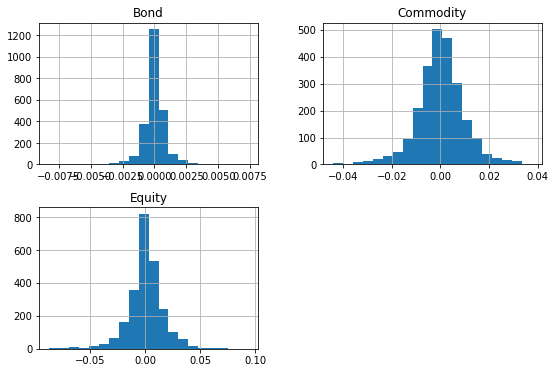

In [8]:
df_percentage_return.hist(bins=20, figsize=(9, 6))
# tag: real_returns_2
# title: Histogram of respective log-returns
# size: 90

In [9]:
for sym in data.columns:
    print("\nResults for symbol %s" % sym)
    print(30 * "-")
    print_statistics(df_percentage_return[sym].values)


Results for symbol Bond
------------------------------
     statistic           value
------------------------------
          size      2432.00000
           min        -0.00825
           max         0.00733
          mean         0.00001
           std         0.00096
          skew         0.39803
      kurtosis        12.73785

Results for symbol Commodity
------------------------------
     statistic           value
------------------------------
          size      2432.00000
           min        -0.04408
           max         0.03754
          mean         0.00008
           std         0.00982
          skew        -0.19705
      kurtosis         1.87093

Results for symbol Equity
------------------------------
     statistic           value
------------------------------
          size      2432.00000
           min        -0.08748
           max         0.09342
          mean         0.00026
           std         0.01629
          skew        -0.38974
      kurtosis     

### visualize normalized index with start value of 100

/home/weiwu/.virtualenvs/graph/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


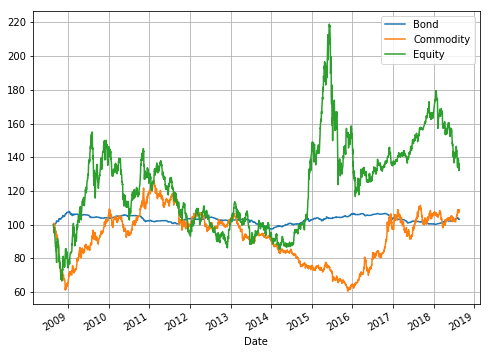

In [10]:
(data / data.ix[0] * 100).plot(figsize=(8, 6), grid=True)
# tag: real_returns_1
# title: Evolution of index levels over time

### Simple Risk Parity
Simple risk parity treats if there is no correlation among assets, thus 
the weight is inversely proportional to recent asset volatility
halflife used to compute asset volatility

Text(0,0.5,'Cumulative Returns')

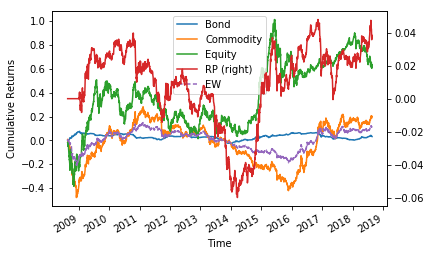

In [14]:
df_std = df_percentage_return.rolling(window =90).std()*np.sqrt(252)
wts = (1/df_std).apply(lambda x: x/((1/df_std).sum(axis=1)))
df_ret_rp = (df_percentage_return * wts.shift(1)).sum(axis=1)
df_ret_static = df_percentage_return.dot(np.array([1/2, 1/2, 0]))

ax = df_percentage_return.cumsum().plot()
df_ret_rp.cumsum().to_frame("RP").plot(ax =ax, secondary_y= True)
(df_ret_static).to_frame("EW").cumsum().plot(ax=ax, style=['--'])

ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Returns")

Text(0,0.5,'Risk Contribution')

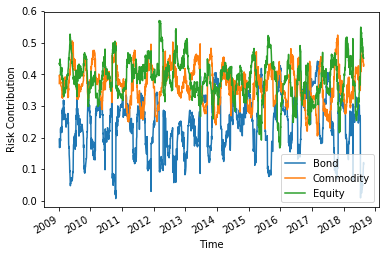

In [15]:
pt_risk_contribution = wts * 0
weighting_scheme = "NRP"
# weighting_scheme = "60-40"
lookback = 60
for i in np.arange(len(wts)):
    if i >= lookback:
        if weighting_scheme == "NRP":
            wts_vec = wts.iloc[i]
        elif weighting_scheme == "60-40":
            wts_vec = np.array([0.6,0.4])
            
        Sigma = df_percentage_return.iloc[i-lookback+1:i,:].cov()
        var_p = wts_vec.dot(Sigma).dot(wts_vec)
        risk_contribution_vec = (wts_vec * (Sigma.dot(wts_vec)))/var_p
        pt_risk_contribution.iloc[i,:] = np.array(risk_contribution_vec)

ax = pt_risk_contribution.plot()
ax.set_xlabel("Time")
ax.set_ylabel("Risk Contribution")
#ax.set_title("Risk Contribution (Weighting Scheme: " + weighting_scheme + ")")

In [16]:
#-------------------------------------
# Weighted arrays
#-------------------------------------
syd_array = np.arange(1, lookback+1)/np.arange(1, lookback+1).sum()
syd_array = syd_array.reshape(-1, 1)
log_array = np.log(np.arange(lookback)+1)/np.log(np.arange(lookback)+1).sum()
log_array = log_array.reshape(-1, 1)
sqrt_array = np.sqrt(np.arange(lookback)+1)/np.sqrt(np.arange(lookback)+1).sum()
sqrt_array = sqrt_array.reshape(-1, 1)

In [20]:
#-------------------------------------
# Naive risk parity weight calc
#-------------------------------------
t1 = time.time()
df_returns = data.iloc[:,:2].pct_change()

# if 'Equity' in df_returns.columns:
#   df_returns['Equity'] *= -1               # Adjust for short sale
#    df_returns['Equity'] -= .065/periodicity # Adjust for borrow cost

df_RV = np.sqrt(periodicity/lookback*(np.log(1+df_returns)**2).rolling(lookback).sum())*100
arr_IV = np.array(1/df_RV)
IV_wt_arr = arr_IV/arr_IV.sum(axis=1).reshape(-1, 1)
df_IV_weights = pd.DataFrame(index=df_RV.index, columns=df_RV.columns, data=IV_wt_arr)

#if 'Equity' in df_returns.columns:
#    df_returns['Equity'] *= -1               # Re-adjust for short sale
#    df_IV_weights['Equity'] *= -1

IV_returns = (df_IV_weights.shift(1)*df_returns).sum(axis=1)
print("{0:,.5f}".format(time.time()-t1), 'seconds')
df_IV_weights.tail(1)

0.02117 seconds


,Bond,Commodity
Date,,
2018-08-21,0.88492,0.11508


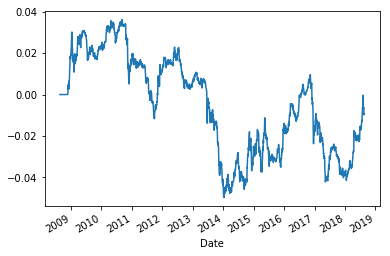

In [21]:
IV_returns.cumsum().plot()